In [ ]:
# !pip install optuna
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import confusion_matrix
import seaborn as sns
# import optuna

In [ ]:
torch.cuda.device_count()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
data_transform = transforms.Compose([
    # transforms.RandomRotation(10),
    # transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,))
])

In [ ]:
training_data_set = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=data_transform
)

In [ ]:
test_data_set = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=False,
    transform=data_transform
)

In [ ]:
batch_size = 16
max_epochs = 10

In [ ]:
training_data_loader = torch.utils.data.DataLoader(training_data_set, batch_size=batch_size, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size=batch_size, shuffle=False)

In [ ]:
classes = tuple([str(i) for i in range(0, 10)])
classes

('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

torch.Size([16, 1, 28, 28])
<class 'torch.Tensor'>


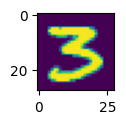

In [ ]:
data_iterator = iter(training_data_loader)
images, labels = next(data_iterator)
print(images.shape)
img = images[0]
print(type(img))
np_img = img.numpy()
np_img.shape
np_img = np.transpose(np_img, (1, 2, 0))
np_img.shape
plt.figure(figsize=(1,1))
plt.imshow(np_img)
plt.show()

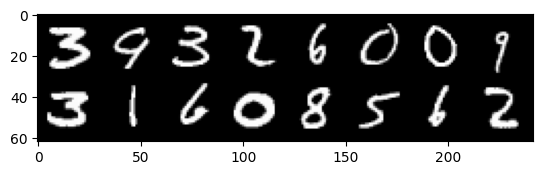

3 9 3 2 6 0 0 9 3 1 6 0 8 5 6 2


In [ ]:
def show_img(img):
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img, (1, 2, 0)))
  plt.show()
show_img(torchvision.utils.make_grid(images))
print(' '.join(classes[labels[j]] for j in range(16)))

In [ ]:
import torch.nn as nn
import torch.nn.init as init

class CNN(nn.Module):
  def __init__(self, number_of_classes=10, dropout_prob=0.1):
    super(CNN, self).__init__()
    self.hidden_layers = nn.Sequential(
        nn.Conv2d(1, 16, 7, padding=3, stride=(1, 1)),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2, stride=2, padding=0),
        # nn.Dropout(p=dropout_prob),
        nn.Conv2d(16, 8, 5, padding=2, stride=(1, 1)),
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.MaxPool2d(2, stride=1, padding=0),
        # nn.Dropout(p=dropout_prob),
        nn.Conv2d(8, 4, 3, padding=1, stride=(2, 2)),
        nn.BatchNorm2d(4),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2, padding=0)
    )
    self.full_layer = nn.Sequential(
        nn.Linear(36, number_of_classes),
        # nn.BatchNorm1d(number_of_classes),
        # nn.Dropout(p=dropout_prob)
    )

    for layer in [self.hidden_layers[0], self.hidden_layers[3], self.hidden_layers[6]]:
      if isinstance(layer, nn.Conv2d):
        init.kaiming_normal_(layer.weight, nonlinearity='relu')
    if isinstance(self.full_layer[0], nn.Linear):
      init.xavier_uniform_(self.full_layer[0].weight)

  def forward(self, x):
    x = self.hidden_layers(x)
    x = x.view(x.size(0), -1)
    x = self.full_layer(x)
    return x

In [ ]:
neural_network = CNN().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(neural_network.parameters(), lr=0.0007397562500059919, betas=(0.3193992609214785, 0.999), weight_decay=8.145610384339306e-05)
for p in optimizer.param_groups:
  p['clip_grad_norm'] = 0.2
scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.22376131081583442)

In [ ]:
total_params = sum(p.numel() for p in neural_network.parameters())
trainable_params = sum(p.numel() for p in neural_network.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params

print(total_params, trainable_params, non_trainable_params)

4726 4726 0


In [ ]:
all_labels_10Class = []
all_predicted_10Class = []
def evaluation(data_loader, is_10Class=False):
  neural_network.eval()
  total, correct = 0, 0

  with torch.no_grad():
    for data in data_loader:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = neural_network(inputs)
      _, prediction = torch.max(outputs.data, 1)
      total = total + labels.size(0)
      correct = correct + (prediction == labels).sum().item()
      if is_10Class:
        all_labels_10Class.extend(labels.cpu().numpy())
        all_predicted_10Class.extend(prediction.cpu().numpy())
  return correct * 100 / total

In [ ]:
%%time
loss_epoch_arr = []
training_accuracy_per_epoch = []
testing_accuracy_per_epoch = []

for epoch in range(max_epochs):
  for i, data in enumerate(training_data_loader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = neural_network(inputs)
    loss = loss_function(outputs, labels)

    lambda_reg = 1e-5
    l2_regularization = 0.0
    for param in neural_network.parameters():
      l2_regularization += torch.sum(param**2)
    l2_regularization = torch.sqrt(l2_regularization)
    loss += lambda_reg * l2_regularization

    loss.backward()
    torch.nn.utils.clip_grad_norm_(neural_network.parameters(), max_norm=1)
    optimizer.step()
  loss_epoch_arr.append(loss.item())
  scheduler.step()
  accuracy = evaluation(training_data_loader)
  accuracy_testing = evaluation(test_data_loader)
  training_accuracy_per_epoch.append(accuracy / 100)
  testing_accuracy_per_epoch.append(accuracy_testing / 100)
  print(f"Epoch: {epoch+1}/{max_epochs}, Loss: {loss}, Test_Accuracy: {accuracy_testing}, Trainig_Accuracy: {accuracy}")

Epoch: 1/10, Loss: 0.3213430345058441, Test_Accuracy: 97.02, Trainig_Accuracy: 96.69
Epoch: 2/10, Loss: 0.011558739468455315, Test_Accuracy: 98.05, Trainig_Accuracy: 97.76
Epoch: 3/10, Loss: 0.00015601995983161032, Test_Accuracy: 98.48, Trainig_Accuracy: 98.52333333333333
Epoch: 4/10, Loss: 0.008141228929162025, Test_Accuracy: 98.58, Trainig_Accuracy: 98.665
Epoch: 5/10, Loss: 0.00046364543959498405, Test_Accuracy: 98.61, Trainig_Accuracy: 98.78833333333333
Epoch: 6/10, Loss: 0.0005423378315754235, Test_Accuracy: 98.68, Trainig_Accuracy: 98.85166666666667
Epoch: 7/10, Loss: 0.0036113103851675987, Test_Accuracy: 98.67, Trainig_Accuracy: 98.86166666666666
Epoch: 8/10, Loss: 0.0005322430515661836, Test_Accuracy: 98.71, Trainig_Accuracy: 98.86333333333333
Epoch: 9/10, Loss: 0.0008227137732319534, Test_Accuracy: 98.71, Trainig_Accuracy: 98.86666666666666
Epoch: 10/10, Loss: 0.00022934288426768035, Test_Accuracy: 98.68, Trainig_Accuracy: 98.865
CPU times: user 8min 20s, sys: 2.75 s, total: 8

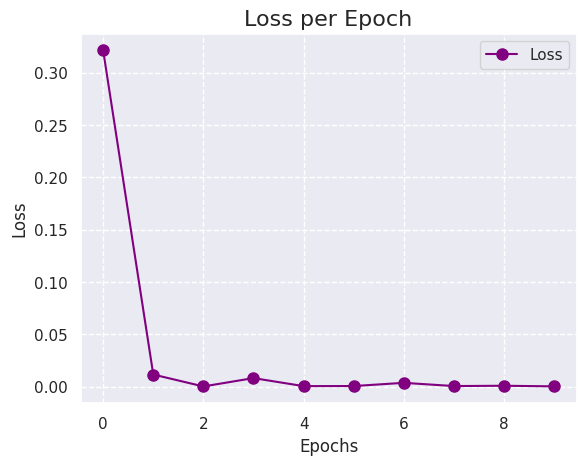

In [ ]:
sns.set(style='darkgrid')
plt.plot(loss_epoch_arr, label="Loss", color="purple", linestyle='-', marker='o', markersize=8)
plt.title("Loss per Epoch", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, linestyle='--', alpha=1)
plt.legend()
plt.show()

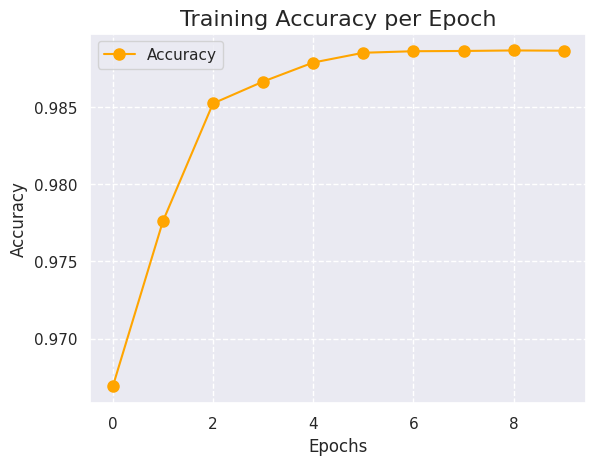

In [ ]:
plt.plot(training_accuracy_per_epoch, label="Accuracy", color="orange", linestyle='-', marker='o', markersize=8)
plt.title("Training Accuracy per Epoch", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True, linestyle='--', alpha=1)
plt.legend()
plt.show()

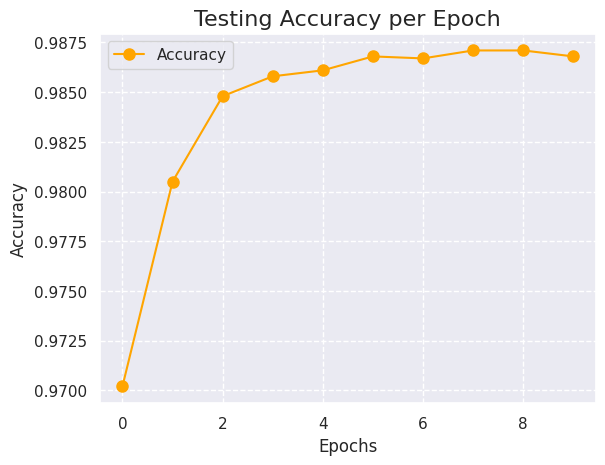

In [ ]:
plt.plot(testing_accuracy_per_epoch, label="Accuracy", color="orange", linestyle='-', marker='o', markersize=8)
plt.title("Testing Accuracy per Epoch", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True, linestyle='--', alpha=1)
plt.legend()
plt.show()

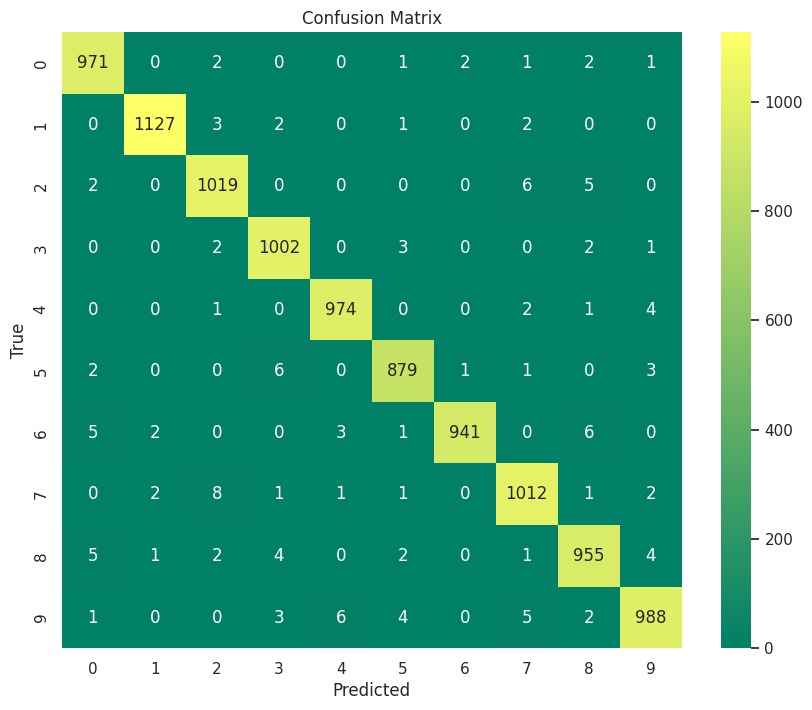

In [ ]:
evaluation(test_data_loader, is_10Class=True)
c_matrix = confusion_matrix(all_labels_10Class, all_predicted_10Class)
plt.figure(figsize=(10, 8))
sns.heatmap(c_matrix, annot=True, fmt='d', cmap='summer', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
class_mapping = {
    0: 0,
    6: 0,
    1: 1,
    7: 1,
    2: 2,
    3: 2,
    8: 2,
    5: 2,
    4: 3,
    9: 3,
}

In [ ]:
def map_classes(labels):
    return [class_mapping[label.item()] for label in labels]

In [ ]:
training_data_set.targets = torch.tensor(map_classes(training_data_set.targets))
test_data_set.targets = torch.tensor(map_classes(test_data_set.targets))
train_loader = torch.utils.data.DataLoader(dataset= training_data_set, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset= test_data_set, batch_size = batch_size, shuffle = True)

In [ ]:
neural_network_4Class = CNN(number_of_classes=4).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(neural_network_4Class.parameters(), lr=0.0004304301906694783, betas=(0.5669888954822534, 0.999), weight_decay=1.6131467676295329e-06)
for p in optimizer.param_groups:
  p['clip_grad_norm'] = 0.2
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7441961151320412)

In [ ]:
total_params = sum(p.numel() for p in neural_network_4Class.parameters())
trainable_params = sum(p.numel() for p in neural_network_4Class.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params

print(total_params, trainable_params, non_trainable_params)

4504 4504 0


In [ ]:
all_labels_4Class = []
all_predicted_4Class = []
def evaluation2(data_loader, is_4Class=False):
  neural_network_4Class.eval()
  total, correct = 0, 0
  with torch.no_grad():
    for data in data_loader:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = neural_network_4Class(inputs)
      _, prediction = torch.max(outputs.data, 1)
      total = total + labels.size(0)
      correct = correct + (prediction == labels).sum().item()
      if is_4Class:
        all_labels_4Class.extend(labels.cpu().numpy())
        all_predicted_4Class.extend(prediction.cpu().numpy())
  return correct * 100 / total

In [ ]:
%%time
loss_epoch_arr = []
training_accuracy_per_epoch = []
testing_accuracy_per_epoch = []
for epoch in range(max_epochs):
  neural_network_4Class.train()
  for i, data in enumerate(train_loader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = neural_network_4Class(inputs)
    loss = loss_function(outputs, labels)

    lambda_reg = 1e-5
    l2_regularization = 0.0
    for param in neural_network_4Class.parameters():
      l2_regularization += torch.sum(param**2)
    l2_regularization = torch.sqrt(l2_regularization)
    loss += lambda_reg * l2_regularization

    loss.backward()
    optimizer.step()
  loss_epoch_arr.append(loss.item())
  scheduler.step()
  accuracy = evaluation2(train_loader)
  accuracy_testing = evaluation2(test_loader)
  training_accuracy_per_epoch.append(accuracy / 100)
  testing_accuracy_per_epoch.append(accuracy_testing / 100)
  print(f"Epoch: {epoch+1}/{max_epochs}, Loss: {loss}, Test_Accuracy: {accuracy_testing}, Trainig_Accuracy: {accuracy}")

Epoch: 1/10, Loss: 0.012256194837391376, Test_Accuracy: 98.47, Trainig_Accuracy: 98.25833333333334
Epoch: 2/10, Loss: 0.0840294361114502, Test_Accuracy: 98.89, Trainig_Accuracy: 98.78333333333333
Epoch: 3/10, Loss: 0.05938242748379707, Test_Accuracy: 98.95, Trainig_Accuracy: 99.1
Epoch: 4/10, Loss: 0.007144179195165634, Test_Accuracy: 99.04, Trainig_Accuracy: 99.22166666666666
Epoch: 5/10, Loss: 0.00696888891980052, Test_Accuracy: 99.1, Trainig_Accuracy: 99.29
Epoch: 6/10, Loss: 0.0073064640164375305, Test_Accuracy: 99.24, Trainig_Accuracy: 99.43833333333333
Epoch: 7/10, Loss: 0.012116598896682262, Test_Accuracy: 99.19, Trainig_Accuracy: 99.50333333333333
Epoch: 8/10, Loss: 0.015461750328540802, Test_Accuracy: 99.18, Trainig_Accuracy: 99.51166666666667
Epoch: 9/10, Loss: 0.003552535315975547, Test_Accuracy: 99.34, Trainig_Accuracy: 99.58
Epoch: 10/10, Loss: 0.005953142419457436, Test_Accuracy: 99.27, Trainig_Accuracy: 99.60833333333333
CPU times: user 8min 23s, sys: 2.95 s, total: 8min

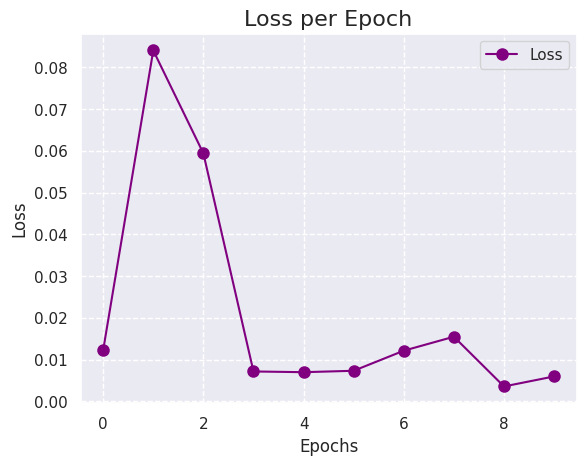

In [ ]:
plt.plot(loss_epoch_arr, label="Loss", color="purple", linestyle='-', marker='o', markersize=8)
plt.title("Loss per Epoch", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, linestyle='--', alpha=1)
plt.legend()
plt.show()

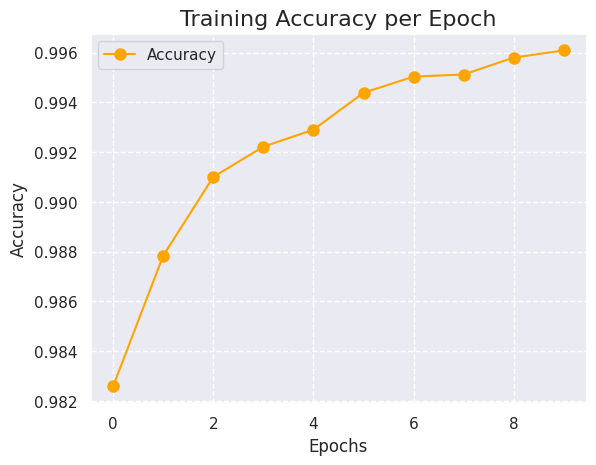

In [ ]:
plt.plot(training_accuracy_per_epoch, label="Accuracy", color="orange", linestyle='-', marker='o', markersize=8)
plt.title("Training Accuracy per Epoch", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True, linestyle='--', alpha=1)
plt.legend()
plt.show()

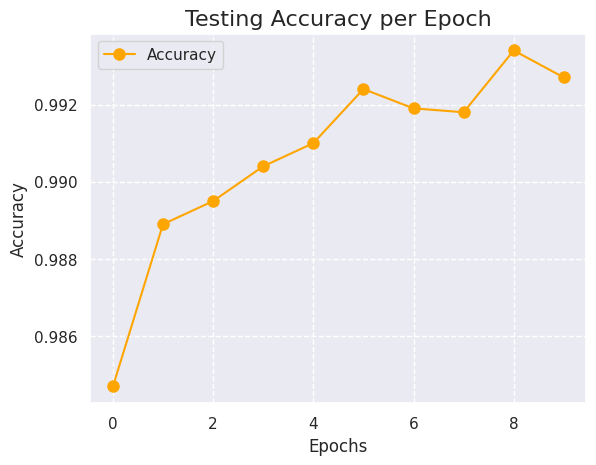

In [ ]:
plt.plot(testing_accuracy_per_epoch, label="Accuracy", color="orange", linestyle='-', marker='o', markersize=8)
plt.title("Testing Accuracy per Epoch", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True, linestyle='--', alpha=1)
plt.legend()
plt.show()

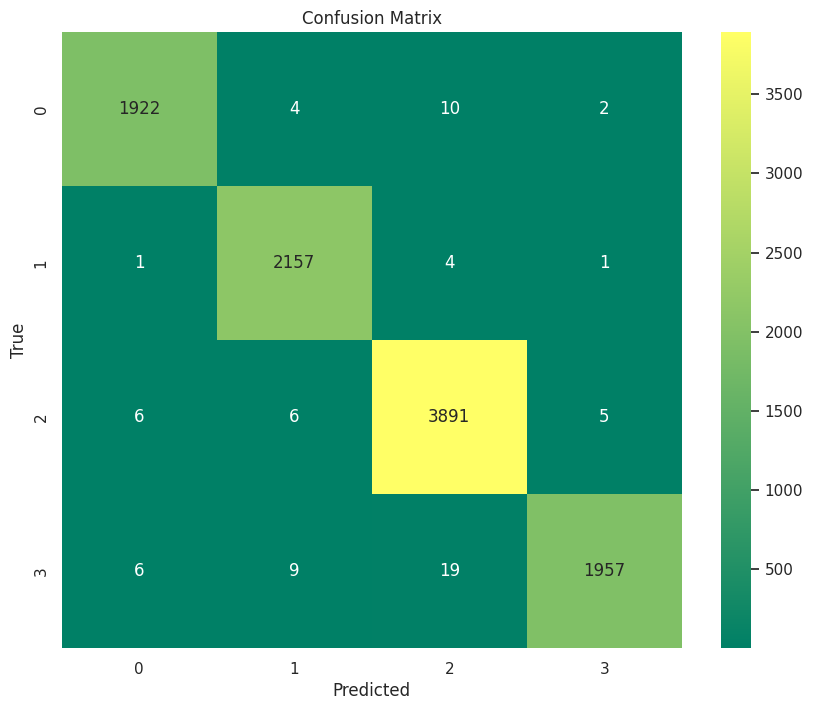

In [ ]:
evaluation2(test_loader, is_4Class=True)
c_matrix2 = confusion_matrix(all_labels_4Class, all_predicted_4Class, labels=[0, 1, 2, 3])
plt.figure(figsize=(10, 8))
sns.heatmap(c_matrix2, annot=True, fmt='d', cmap='summer', xticklabels=range(4), yticklabels=range(4))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

print(c_matrix2)
sm = 0
for i in c_matrix:
  sm += sum(i)
print(sm)

[[1922    4   10    2]
 [   1 2157    4    1]
 [   6    6 3891    5]
 [   6    9   19 1957]]
10000


In [ ]:
# def hyperparameters(trial):
#   learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
#   # batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
#   weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
#   dropout_prob = trial.suggest_float('dropout_prob', 0.0, 0.5)
#   # momentum = trial.suggest_float('momentum', 0.0, 0.9)
#   step_size = trial.suggest_int('step_size', 1, 10)
#   gamma = trial.suggest_float('gamma', 0.1, 0.9)
#   beta1 = trial.suggest_float('beta1', 0.1, 0.9)


#   loss_function = nn.CrossEntropyLoss()
#   optimizer = optim.Adam(neural_network.parameters(), lr=learning_rate, betas=(beta1, 0.999), weight_decay=weight_decay)
#   scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

#   loss_epoch_arr = []
#   accuracy_per_epoch = []
#   for epoch in range(max_epochs):
#     for i, data in enumerate(training_data_loader):
#       inputs, labels = data
#       inputs, labels = inputs.to(device), labels.to(device)
#       optimizer.zero_grad()
#       outputs = neural_network(inputs)
#       loss = loss_function(outputs, labels)
#       l2_regularization = 0.0
#       for param in neural_network.parameters():
#         l2_regularization += torch.norm(param, 2)
#       loss += 1e-5 * l2_regularization
#       loss.backward()
#       torch.nn.utils.clip_grad_norm_(neural_network.parameters(), max_norm=1)
#       optimizer.step()
#     loss_epoch_arr.append(loss.item())
#     scheduler.step()
#     accuracy = evaluation(training_data_loader)
#     accuracy_per_epoch.append(accuracy / 100)
#     # print(f"Epoch: {epoch+1}/{max_epochs}, Loss: {loss}, Test_Accuracy: {evaluation(test_data_loader)}, Trainig_Accuracy: {evaluation(training_data_loader)}")
#     print(f"Epoch: {epoch+1}/{max_epochs}, Loss: {loss}, Test_Accuracy: {evaluation(test_data_loader)}, Trainig_Accuracy: {accuracy}")

#   accuracy = evaluation(test_loader)
#   return loss_epoch_arr[-1]

# study = optuna.create_study(direction='minimize')
# study.optimize(hyperparameters, n_trials=15)
# best_params = study.best_params
# best_learning_rate = best_params['learning_rate']
# # best_batch_size = best_params['batch_size']
# best_weight_decay = best_params['weight_decay']
# best_dropout_prob = best_params['dropout_prob']
# # best_momentum = best_params['momentum']
# best_step_size = best_params['step_size']
# best_gamma = best_params['gamma']
# best_beta1 = best_params['beta1']

# print("Best Hyperparameters:")
# print("Learning Rate:", best_learning_rate)
# # print("Batch Size:", best_batch_size)
# print("Weight Decay:", best_weight_decay)
# print("Dropout Probability:", best_dropout_prob)
# # print("Momentum:", best_momentum)
# print("Step Size for LR Scheduler:", best_step_size)
# print("Gamma for LR Scheduler:", best_gamma)
# print("Beta1 (Momentum in Adam):", best_beta1)

In [ ]:
# def hyperparameters(trial):
#   learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
#   # batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
#   weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
#   dropout_prob = trial.suggest_float('dropout_prob', 0.0, 0.5)
#   # momentum = trial.suggest_float('momentum', 0.0, 0.9)
#   step_size = trial.suggest_int('step_size', 1, 10)
#   gamma = trial.suggest_float('gamma', 0.1, 0.9)
#   beta1 = trial.suggest_float('beta1', 0.1, 0.9)


#   loss_function = nn.CrossEntropyLoss()
#   optimizer = optim.Adam(neural_network_4Class.parameters(), lr=learning_rate, betas=(beta1, 0.999), weight_decay=weight_decay)
#   scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

#   loss_epoch_arr = []
#   accuracy_per_epoch = []
#   for epoch in range(max_epochs):
#     for i, data in enumerate(train_loader):
#       inputs, labels = data
#       inputs, labels = inputs.to(device), labels.to(device)
#       optimizer.zero_grad()
#       outputs = neural_network_4Class(inputs)
#       loss = loss_function(outputs, labels)
#       # l2_regularization = 0.0
#       # for param in neural_network_4Class.parameters():
#       #   l2_regularization += torch.norm(param, 2)
#       # loss += 1e-4 * l2_regularization

#       lambda_reg = 1e-5
#       l2_regularization = 0.0
#       for param in neural_network_4Class.parameters():
#         l2_regularization += torch.sum(param**2)
#       l2_regularization = torch.sqrt(l2_regularization)
#       loss += lambda_reg * l2_regularization

#       loss.backward()
#       optimizer.step()
#     loss_epoch_arr.append(loss.item())
#     scheduler.step()
#     accuracy = evaluation2(train_loader)
#     accuracy_per_epoch.append(accuracy / 100)
#     # print(f"Epoch: {epoch+1}/{max_epochs}, Loss: {loss}, Test_Accuracy: {evaluation2(test_loader)}, Trainig_Accuracy: {evaluation2(train_loader)}")
#     print(f"Epoch: {epoch+1}/{max_epochs}, Loss: {loss}, Test_Accuracy: {evaluation2(test_loader)}, Trainig_Accuracy: {accuracy}")
#     accuracy = evaluation2(test_loader)
#   return loss_epoch_arr[-1]

# study = optuna.create_study(direction='minimize')
# study.optimize(hyperparameters, n_trials=10)
# best_params = study.best_params
# best_learning_rate = best_params['learning_rate']
# # best_batch_size = best_params['batch_size']
# best_weight_decay = best_params['weight_decay']
# best_dropout_prob = best_params['dropout_prob']
# # best_momentum = best_params['momentum']
# best_step_size = best_params['step_size']
# best_gamma = best_params['gamma']
# best_beta1 = best_params['beta1']

# print("Best Hyperparameters:")
# print("Learning Rate:", best_learning_rate)
# # print("Batch Size:", best_batch_size)
# print("Weight Decay:", best_weight_decay)
# print("Dropout Probability:", best_dropout_prob)
# # print("Momentum:", best_momentum)
# print("Step Size for LR Scheduler:", best_step_size)
# print("Gamma for LR Scheduler:", best_gamma)
# print("Beta1 (Momentum in Adam):", best_beta1)